Step 1: Import Required Libraries

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


Step 2: Load the CIFAR-100 Dataset

In [8]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


Step 3: Build and Train a Simple Model

In [9]:
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build and compile model for CIFAR-100
model = build_model(100)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on CIFAR-100
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0605 - loss: 4.2297 - val_accuracy: 0.1902 - val_loss: 3.4113
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2083 - loss: 3.2787 - val_accuracy: 0.2531 - val_loss: 3.0854
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2694 - loss: 2.9483 - val_accuracy: 0.2892 - val_loss: 2.8890
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3143 - loss: 2.7574 - val_accuracy: 0.3221 - val_loss: 2.7476
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3382 - loss: 2.6153 - val_accuracy: 0.3177 - val_loss: 2.7377
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3636 - loss: 2.4978 - val_accuracy: 0.3429 - val_loss: 2.6299
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3852 - loss: 2.4060 - val_accuracy: 0.3479 - val_loss: 2.6307
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4050 - loss: 2.3158 - val_accuracy: 0.

Step 4: FGSM Attack Implementation

In [10]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the sign of the gradients
    sign_data_grad = tf.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

def create_adversarial_pattern(model, image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, image)
    return gradient

# Create adversarial examples for the entire CIFAR-100 test set
epsilon = 0.1  # Amount of perturbation
adversarial_examples = []

for i in range(len(x_test)):
    img = x_test[i:i+1]
    label = y_test[i:i+1]
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    gradient = create_adversarial_pattern(model, img_tensor, label_tensor)
    adversarial_img = fgsm_attack(img_tensor, epsilon, gradient)
    adversarial_examples.append(adversarial_img.numpy())

adversarial_examples = np.array(adversarial_examples).reshape(-1, 32, 32, 3)


Step 5: Evaluate the Model on Adversarial Examples

In [11]:
# Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adversarial_examples, y_test, verbose=0)
print(f"Accuracy on adversarial examples: {accuracy * 100:.2f}%")


Accuracy on adversarial examples: 0.07%


Step 6: Visualize Adversarial Examples

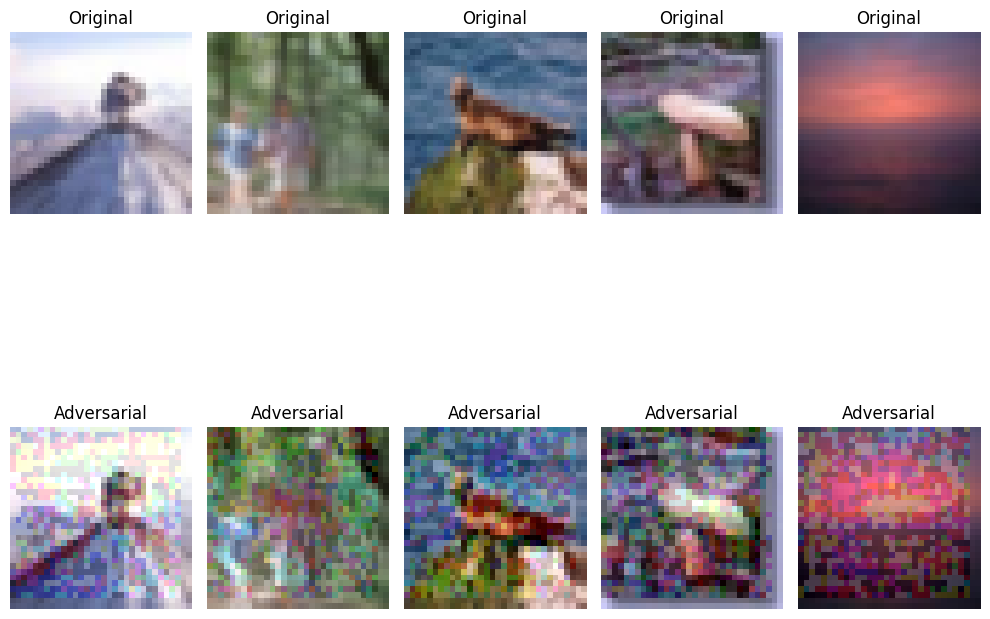

In [12]:
# Visualize original and adversarial examples
num_examples = 5
plt.figure(figsize=(10, 10))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(adversarial_examples[i])
    plt.title("Adversarial")
    plt.axis('off')
plt.tight_layout()
plt.show()

